<a href="https://colab.research.google.com/github/dejunga/ML-Vehicle_Image_Classification/blob/main/train_custom_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries and mount Google Drive**

In [60]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# Set the folder path in Google Drive
save_folder = '/content/drive/My Drive/cifar-10_models&history'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load Data, Filter Training and Test Data for the Desired Classes**

In [61]:
# Step 1: Load CIFAR-100 dataset with coarse labels
(train_images, train_coarse_labels), (test_images, test_coarse_labels) = datasets.cifar100.load_data(label_mode='coarse')

# Load CIFAR-100 dataset with fine labels (to use for display)
(_, train_fine_labels), (_, test_fine_labels) = datasets.cifar100.load_data(label_mode='fine')

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Fine class names (100 specific classes)
cifar100_fine_labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee',
                        'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly',
                        'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee',
                        'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
                        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
                        'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
                        'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
                        'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
                        'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum',
                        'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark',
                        'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
                        'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone',
                        'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
                        'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# Coarse class names (20 superclasses including 'vehicles 1' and 'vehicles 2')
cifar100_coarse_classes = ['aquatic mammals', 'fish', 'flowers', 'food containers',
                           'fruit and vegetables', 'household electrical devices',
                           'household furniture', 'insects', 'large carnivores',
                           'large man-made outdoor things', 'large natural outdoor scenes',
                           'large omnivores and herbivores', 'medium-sized mammals',
                           'non-insect invertebrates', 'people', 'reptiles', 'small mammals',
                           'trees', 'vehicles 1', 'vehicles 2']

# Step 2: Superclasses you want to display: 'vehicles 1' and 'vehicles 2'
desired_classes = ['vehicles 1', 'vehicles 2']

# Map desired superclasses to their corresponding indices
desired_class_indices = [cifar100_coarse_classes.index(cls) for cls in desired_classes]

# Step 3: Filter train images and labels to only include desired superclasses
filtered_images = []
filtered_labels = []
filtered_fine_labels = []  # This will store fine labels for display purposes
for i in range(len(train_coarse_labels)):
    if train_coarse_labels[i][0] in desired_class_indices:
        filtered_images.append(train_images[i])
        filtered_labels.append(train_coarse_labels[i][0])
        filtered_fine_labels.append(train_fine_labels[i][0])  # Fine labels

# Convert to NumPy arrays
filtered_images = np.array(filtered_images)
filtered_labels = np.array(filtered_labels)
filtered_fine_labels = np.array(filtered_fine_labels)

# Step 4: Filter test images and labels to only include desired superclasses
filtered_test_images = []
filtered_test_labels = []
filtered_test_fine_labels = []  # This will store fine labels for display purposes
for i in range(len(test_coarse_labels)):
    if test_coarse_labels[i][0] in desired_class_indices:
        filtered_test_images.append(test_images[i])
        filtered_test_labels.append(test_coarse_labels[i][0])
        filtered_test_fine_labels.append(test_fine_labels[i][0])  # Fine labels

# Convert to NumPy arrays
filtered_test_images = np.array(filtered_test_images)
filtered_test_labels = np.array(filtered_test_labels)
filtered_test_fine_labels = np.array(filtered_test_fine_labels)

# Flatten the labels arrays to 1D
filtered_labels = filtered_labels.flatten()
filtered_test_labels = filtered_test_labels.flatten()
filtered_fine_labels = filtered_fine_labels.flatten()
filtered_test_fine_labels = filtered_test_fine_labels.flatten()

# **Display Dataset Statistics (Number of Photos)**

In [62]:
# Print the number of photos in the entire dataset
print(f"Total number of training images: {train_images.shape[0]}")
print(f"Total number of test images: {test_images.shape[0]}")

# Print the number of photos for the selected superclasses
print(f"Number of training images after filtering: {filtered_images.shape[0]}")
print(f"Number of test images after filtering: {filtered_test_images.shape[0]}")

# Print the number of photos for each of the 2 desired superclasses in the training set
for class_idx, class_name in zip(desired_class_indices, desired_classes):
    class_count = sum(train_coarse_labels.flatten() == class_idx)
    print(f"Number of training images for superclass '{class_name}': {class_count}")


# Print the number of photos for each of the 2 desired superclasses in the test set
for class_idx, class_name in zip(desired_class_indices, desired_classes):
    class_count = sum(test_coarse_labels.flatten() == class_idx)
    print(f"Number of test images for superclass '{class_name}': {class_count}")

Total number of training images: 50000
Total number of test images: 10000
Number of training images after filtering: 5000
Number of test images after filtering: 1000
Number of training images for superclass 'vehicles 1': 2500
Number of training images for superclass 'vehicles 2': 2500
Number of test images for superclass 'vehicles 1': 500
Number of test images for superclass 'vehicles 2': 500


## **Display Original Images (No Normalization)**

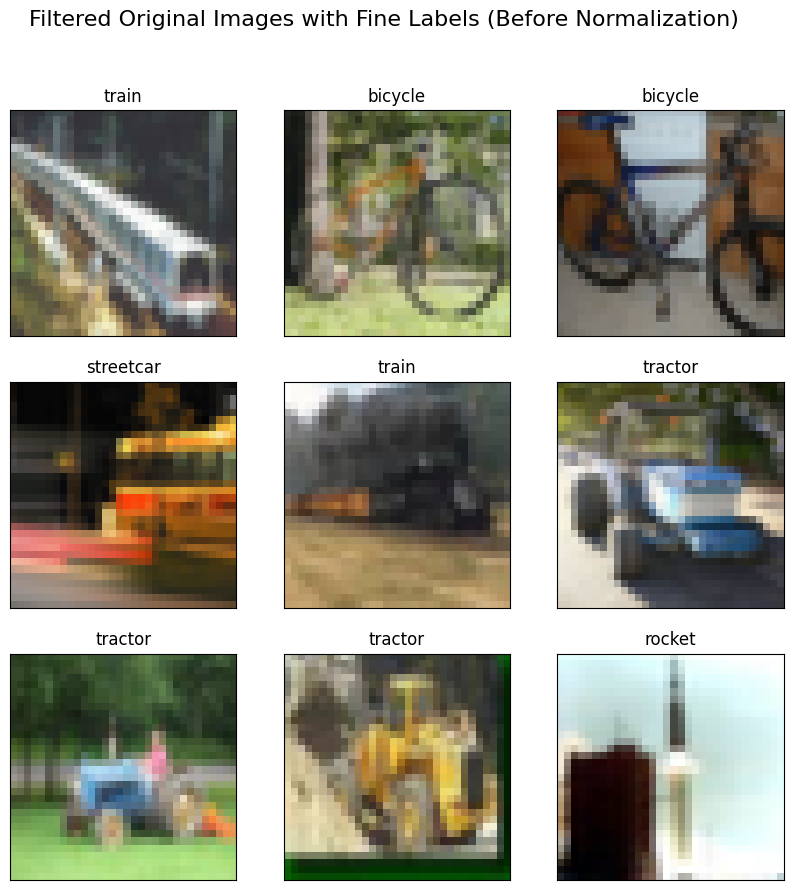

In [63]:
# Step 5: Display the first 9 filtered original images with fine labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(filtered_images[i])  # Use filtered images
    fine_label = cifar100_fine_labels[filtered_fine_labels[i]]  # Get the fine label for each image
    plt.title(fine_label)  # Display the fine label (e.g., 'train', 'tractor')
plt.suptitle("Filtered Original Images with Fine Labels (Before Normalization)", fontsize=16)
plt.show()

## **Display Augmented Images**

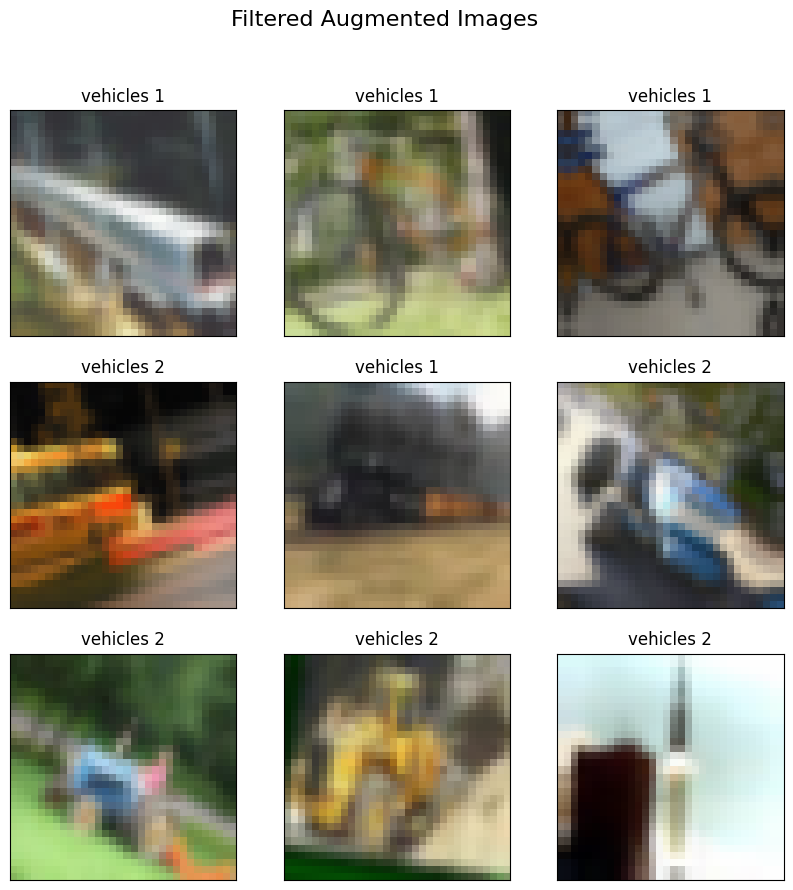

In [64]:
# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply augmentation to the first 9 filtered images and display them
plt.figure(figsize=(10, 10))
for i in range(9):
    # Add batch dimension to pass through the augmentation layer
    augmented_image = tf.expand_dims(filtered_images[i], 0)  # Use filtered images
    augmented_image = data_augmentation(augmented_image)  # Apply augmentation
    augmented_image = tf.squeeze(augmented_image, 0)  # Remove batch dimension

    # Display augmented image
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(augmented_image.numpy())  # Convert tensor to NumPy array for visualization
    plt.title(desired_classes[desired_class_indices.index(filtered_labels[i])])  # Use filtered labels and desired classes
plt.suptitle("Filtered Augmented Images", fontsize=16)
plt.show()

# **Define and Train the Model**

In [65]:
print(f"Shape of filtered_images: {filtered_images.shape}")
print(f"Shape of filtered_test_images: {filtered_test_images.shape}")

Shape of filtered_images: (5000, 32, 32, 3)
Shape of filtered_test_images: (1000, 32, 32, 3)


In [66]:
# Fine labels corresponding to 'vehicles 1' and 'vehicles 2'
fine_labels_vehicles = [8, 13, 41, 48, 58, 69, 81, 85, 89, 90]

# Map the fine labels (8, 13, 41, etc.) to indices 0-9
label_mapping = {fine_label: idx for idx, fine_label in enumerate(fine_labels_vehicles)}

# Apply the mapping to filtered_fine_labels and filtered_test_fine_labels
filtered_fine_labels = np.array([label_mapping[label] for label in filtered_fine_labels])
filtered_test_fine_labels = np.array([label_mapping[label] for label in filtered_test_fine_labels])

In [67]:
print(f"Unique values in filtered_fine_labels: {np.unique(filtered_fine_labels)}")
print(f"Unique values in filtered_test_fine_labels: {np.unique(filtered_test_fine_labels)}")

Unique values in filtered_fine_labels: [0 1 2 3 4 5 6 7 8 9]
Unique values in filtered_test_fine_labels: [0 1 2 3 4 5 6 7 8 9]


In [18]:
# Step 1: Define the Augmentation Pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # Randomly flip images horizontally
    layers.RandomRotation(0.1),  # Randomly rotate images by ±10%
    layers.RandomZoom(0.1),  # Randomly zoom into the image by 10%
])

# Step 2: Define a deeper Model with Batch Normalization and Dropout
model = models.Sequential()
model.add(data_augmentation)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Regularization to avoid overfitting
model.add(layers.Dense(10, activation='softmax'))  # Output layer for 10 fine classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train the model
history = model.fit(filtered_images, filtered_fine_labels, epochs=30,
                    validation_data=(filtered_test_images, filtered_test_fine_labels))

# Step 5: Evaluate the Model
test_loss, test_acc = model.evaluate(filtered_test_images, filtered_test_fine_labels, verbose=2)
print(f"Test accuracy: {test_acc}")

Epoch 1/30
157/157 [==============================] - 6s 24ms/step - loss: 2.4866 - accuracy: 0.1884 - val_loss: 2.2949 - val_accuracy: 0.1030
Epoch 2/30
157/157 [==============================] - 3s 21ms/step - loss: 2.0349 - accuracy: 0.2756 - val_loss: 2.2223 - val_accuracy: 0.1730
Epoch 3/30
157/157 [==============================] - 3s 21ms/step - loss: 1.9319 - accuracy: 0.3092 - val_loss: 1.9827 - val_accuracy: 0.3120
Epoch 4/30
157/157 [==============================] - 3s 21ms/step - loss: 1.8635 - accuracy: 0.3464 - val_loss: 1.7415 - val_accuracy: 0.4130
Epoch 5/30
157/157 [==============================] - 3s 21ms/step - loss: 1.8174 - accuracy: 0.3654 - val_loss: 1.6890 - val_accuracy: 0.4500
Epoch 6/30
157/157 [==============================] - 3s 21ms/step - loss: 1.7552 - accuracy: 0.3864 - val_loss: 1.6948 - val_accuracy: 0.4260
Epoch 7/30
157/157 [==============================] - 3s 21ms/step - loss: 1.7237 - accuracy: 0.4024 - val_loss: 1.6298 - val_accuracy: 0.4540

# **Save the Model and Training History to Google Drive**

In [21]:
# Save the trained model using the recommended .keras format
model_save_path = os.path.join(save_folder, 'custom_model.keras')
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

# Save the training history
history_save_path = os.path.join(save_folder, 'custom_history.pkl')
with open(history_save_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"Training history saved at: {history_save_path}")

Model saved at: /content/drive/My Drive/cifar-10_models&history/custom_model.keras
Training history saved at: /content/drive/My Drive/cifar-10_models&history/custom_history.pkl


# **Check the data counts for each class label**

In [68]:
pd.Series(filtered_fine_labels).value_counts()

,count
9,500
0,500
6,500
8,500
5,500
3,500
7,500
2,500
1,500
4,500


# **Plot the Training History**

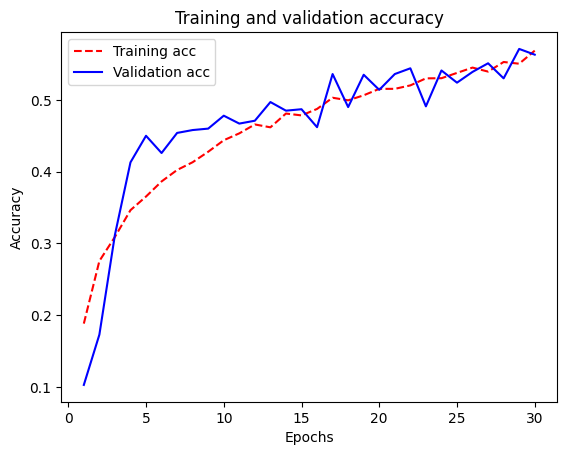

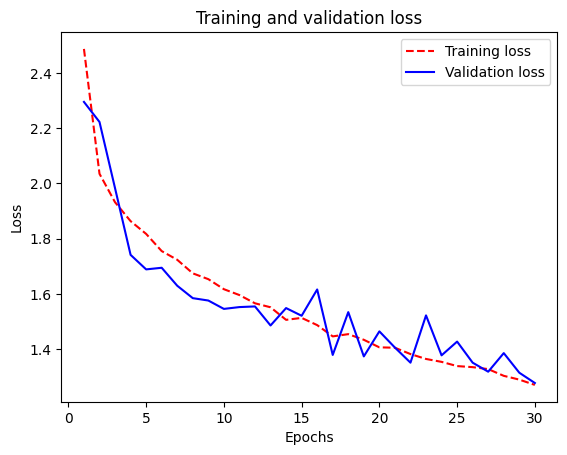

In [69]:
def plot_history(history):
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.plot(epochs, acc, 'r--', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(epochs, loss, 'r--', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

# Call the function to plot
plot_history(history)

# **Create True and Predicted Label DataFrames**

In [70]:
# Fine labels for 'vehicles 1' and 'vehicles 2' classes
fine_labels_vehicles = ['bicycle', 'bus', 'motorcycle', 'pickup truck', 'train',
                        'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']

# Mapping true and predicted labels to names (from the filtered classes)
test_label = filtered_test_fine_labels  # True fine labels
predict_label = model.predict(filtered_test_images).argmax(axis=1)  # Predicted labels

# Map fine labels to corresponding class names for 'vehicles 1' and 'vehicles 2'
label_names = [fine_labels_vehicles[i] for i in test_label]
predict_names = [fine_labels_vehicles[i] for i in predict_label]

# Create a DataFrame to store true and predicted labels
test_predict = pd.DataFrame({
    "label_num": test_label,
    "label_name": label_names,
    "predict_num": predict_label,
    "predict_name": predict_names
})

test_predict.head()

32/32 [==============================] - 0s 4ms/step


,label_num,label_name,predict_num,predict_name
0,6,rocket,4,train
1,5,lawn-mower,5,lawn-mower
2,0,bicycle,0,bicycle
3,0,bicycle,0,bicycle
4,2,motorcycle,2,motorcycle


# **Confusion Matrix**

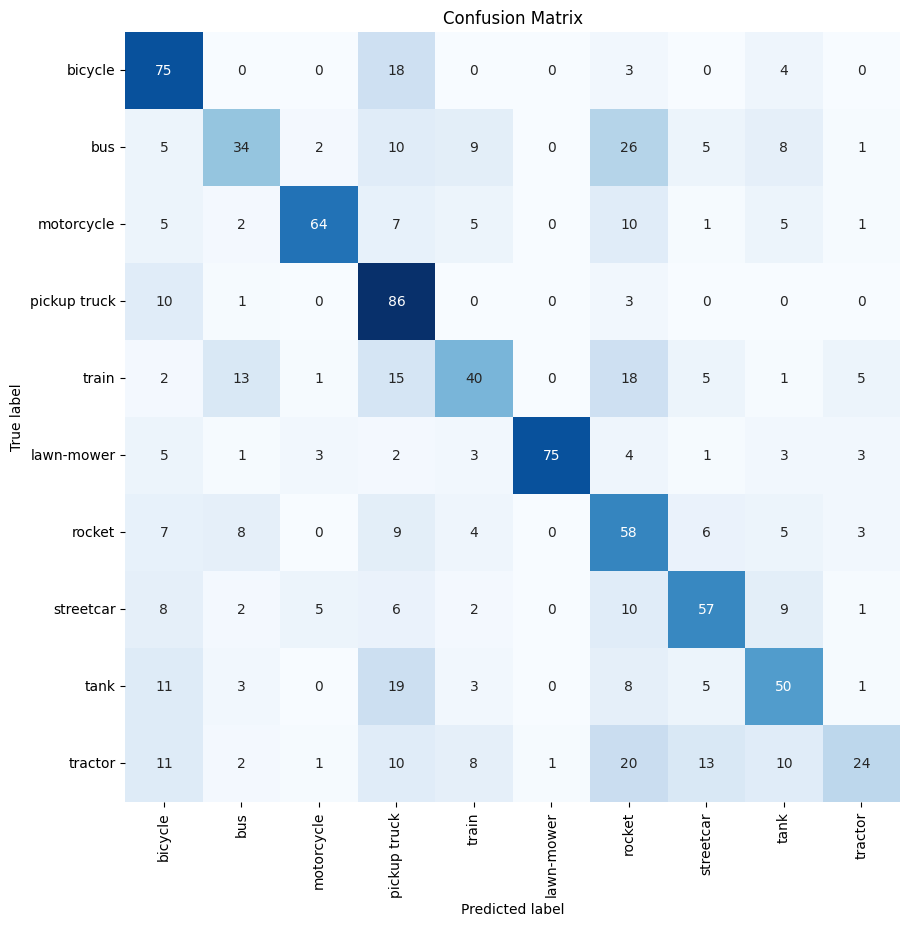

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(test_predict["label_name"], test_predict["predict_name"], labels=fine_labels_vehicles)
n_classes = cm.shape[0]

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="Blues", cbar=False)

ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(0.5, n_classes+0.5),
       yticks=np.arange(0.5, n_classes+0.5),
       xticklabels=fine_labels_vehicles,
       yticklabels=fine_labels_vehicles)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# **Classification Report**

In [72]:
from sklearn.metrics import classification_report

print(classification_report(test_predict["label_name"], test_predict["predict_name"]))

              precision    recall  f1-score   support

     bicycle       0.54      0.75      0.63       100
         bus       0.52      0.34      0.41       100
  lawn-mower       0.99      0.75      0.85       100
  motorcycle       0.84      0.64      0.73       100
pickup truck       0.47      0.86      0.61       100
      rocket       0.36      0.58      0.45       100
   streetcar       0.61      0.57      0.59       100
        tank       0.53      0.50      0.51       100
     tractor       0.62      0.24      0.35       100
       train       0.54      0.40      0.46       100

    accuracy                           0.56      1000
   macro avg       0.60      0.56      0.56      1000
weighted avg       0.60      0.56      0.56      1000



# **F1 Score per Class**

In [73]:
from sklearn.metrics import f1_score
import pandas as pd

# Ensure that f1_score calculates for all 10 classes even if some are missing in predictions
f1_scores = f1_score(test_predict["label_name"], test_predict["predict_name"], average=None, labels=fine_labels_vehicles, zero_division=0)

# Create a DataFrame with the F1 scores and corresponding class names
f1_score_table = pd.DataFrame({
    "Class": fine_labels_vehicles,  # Only 10 classes
    "F1-Score": f1_scores
}).sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

# Display the F1 score table
f1_score_table.head(10)  # Display all 10 rows

,Class,F1-Score
0,lawn-mower,0.852273
1,motorcycle,0.727273
2,bicycle,0.627615
3,pickup truck,0.609929
4,streetcar,0.590674
5,tank,0.512821
6,train,0.459770
7,rocket,0.446154
8,bus,0.409639
9,tractor,0.345324


# **F1-Score Barplot**

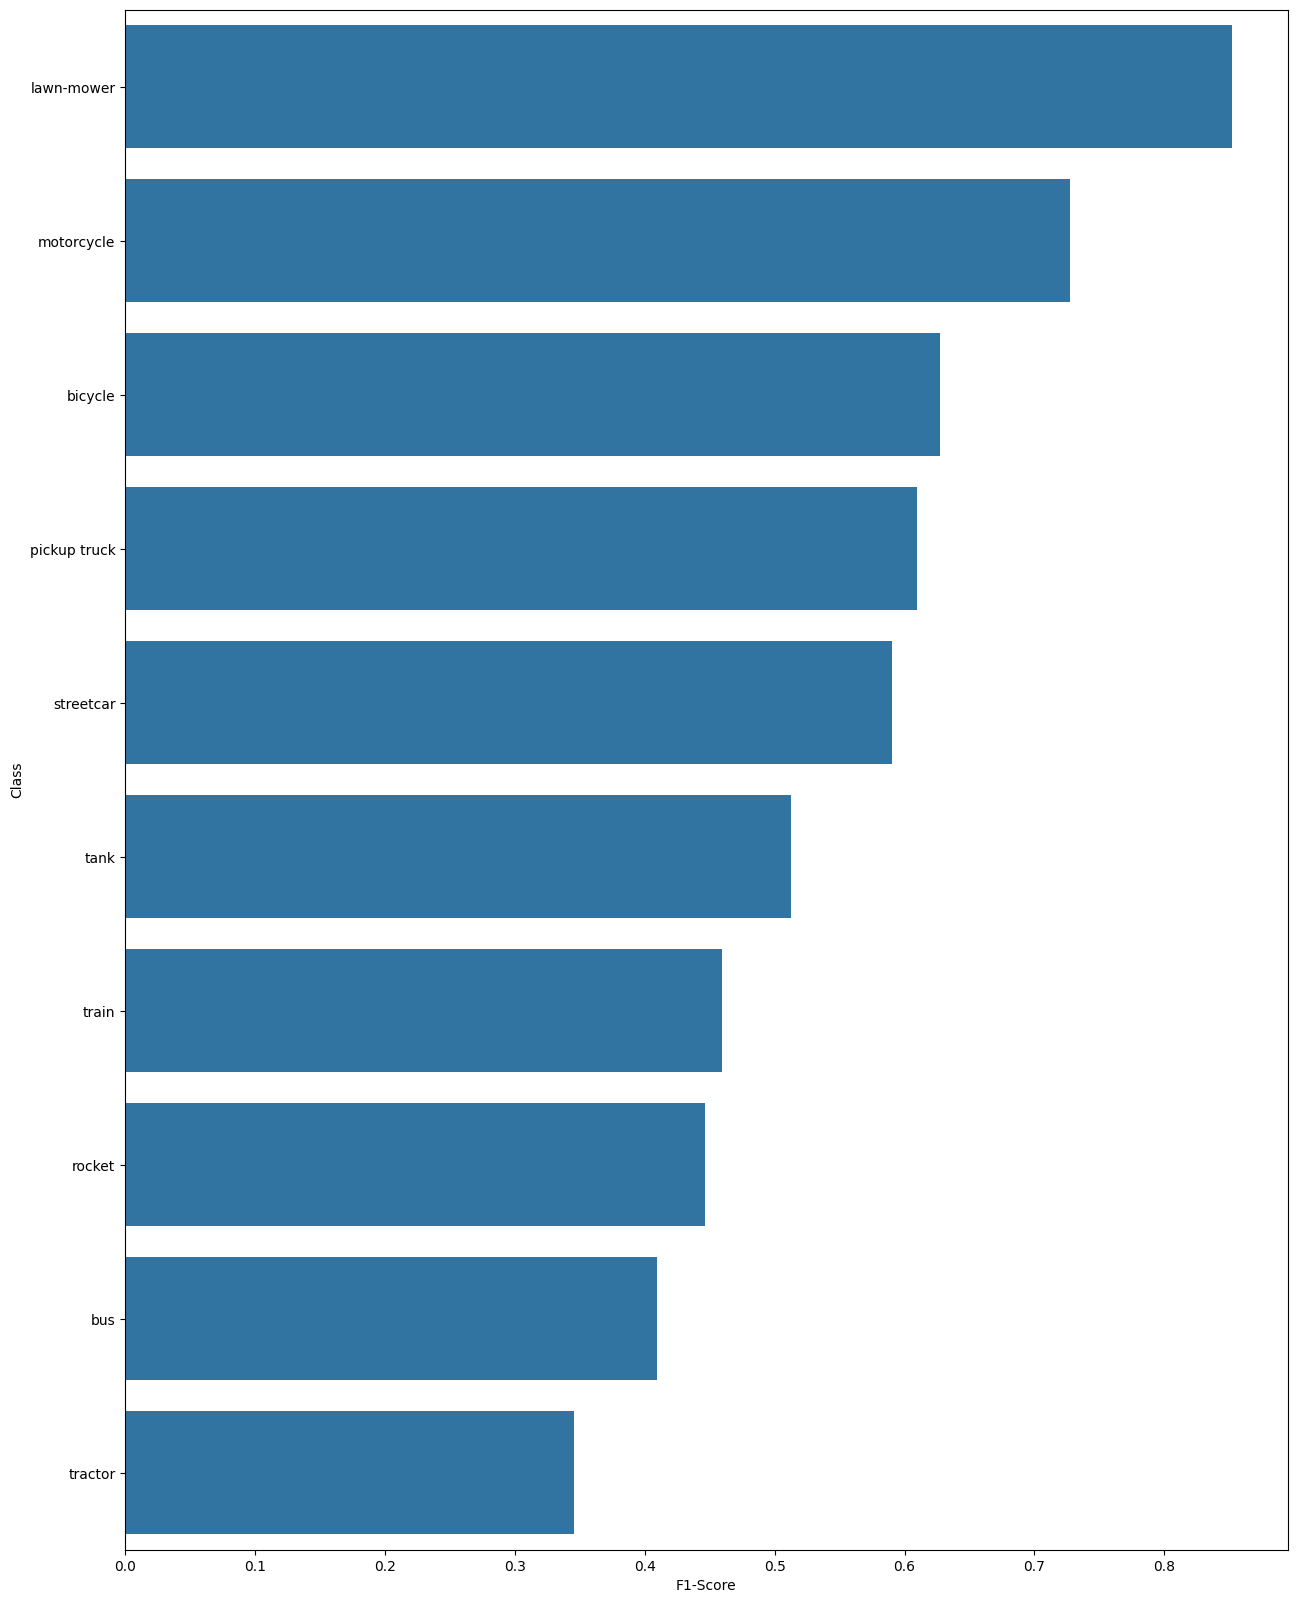

In [74]:
plt.figure(figsize=(15, 20))
sns.barplot(data=f1_score_table, x="F1-Score", y="Class")
plt.show()

# **Check Incorrect Predictions**

In [75]:
# Create column to check if predictions were correct
test_predict["correct_check"] = test_predict["label_num"] == test_predict["predict_num"]

# Predict probabilities
test_predict["pred_conf"] = model.predict(filtered_test_images).max(axis=1)

# Top 100 incorrect predictions
top_100_wrong = test_predict[test_predict["correct_check"] == False].sort_values("pred_conf", ascending=False).head(100)
top_100_wrong.head()

32/32 [==============================] - 0s 4ms/step


,label_num,label_name,predict_num,predict_name,correct_check,pred_conf
146,0,bicycle,3,pickup truck,False,0.989010
459,9,tractor,6,rocket,False,0.939289
24,4,train,0,bicycle,False,0.934753
818,2,motorcycle,3,pickup truck,False,0.921060
975,2,motorcycle,0,bicycle,False,0.904899


# **Visualize Incorrect Predictions**

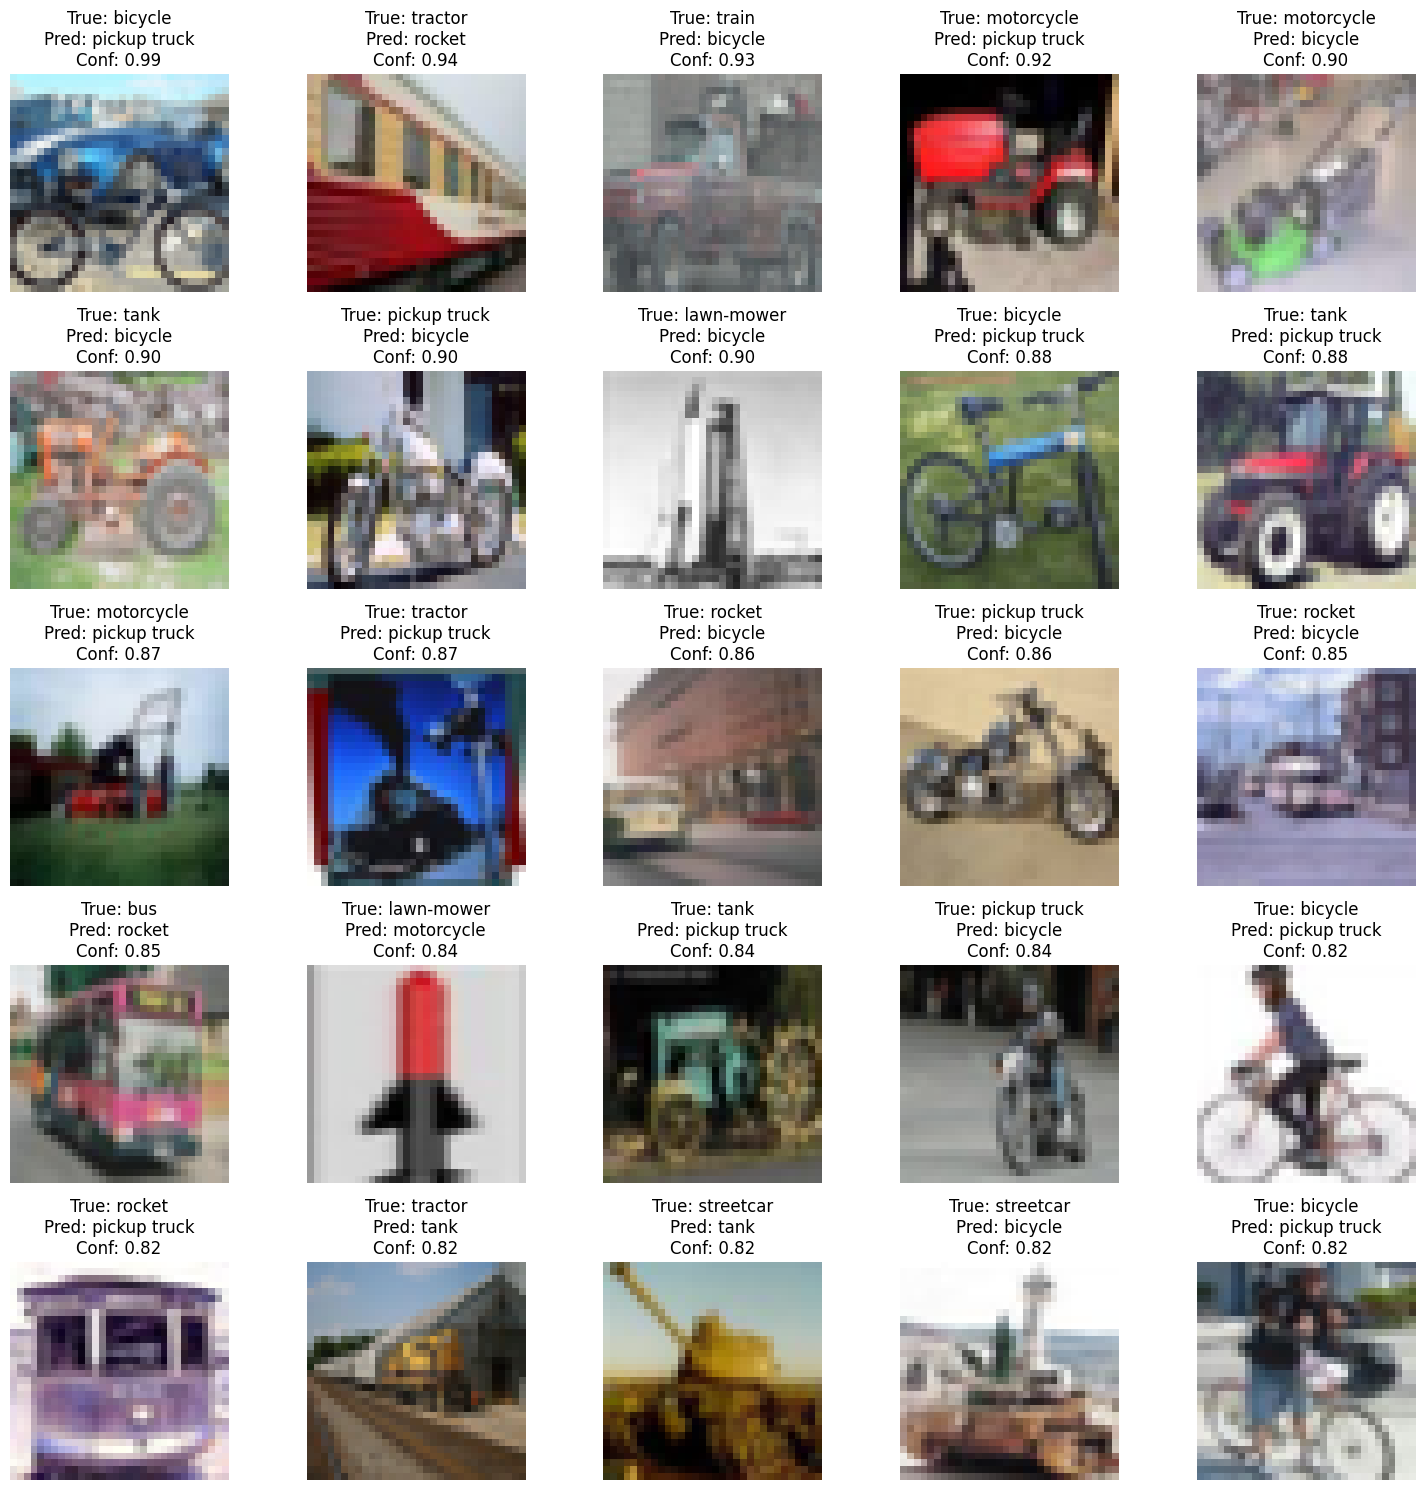

In [76]:
plt.figure(figsize=(15, 15))

# Iterate over top 25 incorrect predictions
for i, row in enumerate(top_100_wrong.head(25).itertuples()):
    plt.subplot(5, 5, i + 1)
    image = filtered_test_images[top_100_wrong.index[i]]  # Use the original index to select the correct image
    label_name = row.label_name
    predict_name = row.predict_name
    pred_conf = row.pred_conf

    plt.imshow(image)
    plt.title(f"True: {label_name}\nPred: {predict_name}\nConf: {pred_conf:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()
